In [1]:
import numpy as np
from PIL import Image
import torch
from torch.utils.data import Dataset

class CocoPerClass(Dataset):
    """
    Each __getitem__ returns:
        img    – PIL.Image (RGB) – the original picture
        cat_id – int – COCO category id (e.g. 62 for chair)
        mask   – torch.uint8 [H,W] 0/1 – union of *all* instances of that class
    """
    def __init__(self, coco_det, transform=None, binarize=True):
        """
        Parameters
        ----------
        coco_det       : torchvision.datasets.CocoDetection
        dino_transform : optional callable(img) -> img
        clip_transform : optional callable(img) -> img
        binarize       : if False, mask pixels hold cat_id instead of {0,1}
        """
        self.coco_det = coco_det
        self.coco = coco_det.coco
        self.transform = transform
        self.binarize = binarize
        
        # Build flat index: [(img_idx, cat_id), ...]
        self._flat_index = []
        for img_idx, img_id in enumerate(coco_det.ids):
            cat_ids = {ann["category_id"] for ann in self.coco.imgToAnns[img_id]}
            self._flat_index.extend((img_idx, cid) for cid in cat_ids)
        
        # ID to name mapping
        self.cat_id2name = {
            c["id"]: c["name"] for c in self.coco.loadCats(self.coco.getCatIds())
        }

    def __len__(self):
        return len(self._flat_index)

    def __getitem__(self, idx):
        img_idx, cat_id = self._flat_index[idx]
        img, anns = self.coco_det[img_idx]
        
        # Keep original image
        original_img = img.copy()
        
        # Build per-class mask
        H, W = img.height, img.width
        mask = np.zeros((H, W), dtype=np.uint8)
        
        for ann in anns:
            if ann["category_id"] == cat_id:
                ann_mask = self.coco.annToMask(ann).astype(bool)
                mask[ann_mask] = 1 if self.binarize else cat_id
        
        # Convert mask to tensor (don't transform it)
        mask = torch.as_tensor(mask, dtype=torch.uint8)
        
        if self.transform is not None:
            img = self.transform(img)
        
        return {
            'image': img,
            'original_image': original_img,
            'category_id': cat_id,
            'mask': mask,
            'category_name': self.cat_id2name[cat_id],
            'image_id': self.coco_det.ids[img_idx],
            'idx': idx
        }

def collate_fn(batch):
    """
    Custom collate function for the CocoPerClass dataset
    """
    images = torch.stack([item['image'] for item in batch])
    original_images = [item['original_image'] for item in batch]
    masks = [item['mask'] for item in batch]
    category_ids = [item['category_id'] for item in batch]
    category_names = [item['category_name'] for item in batch]
    image_ids = [item['image_id'] for item in batch]
    indices = [item['idx'] for item in batch]
    
    return {
        'images': images,
        'original_images': original_images,
        'masks': masks,
        'category_ids': category_ids,
        'category_names': category_names,
        'image_ids': image_ids,
        'indices': indices
    }

In [2]:
from torchvision.datasets import CocoDetection
from torchvision import transforms

img_dir  = "../../dataset/COCO/val2017"
ann_file = "../../dataset/COCO/annotations/instances_val2017.json"

coco_det = CocoDetection(root=img_dir, annFile=ann_file)

dataset = CocoPerClass(coco_det)

loading annotations into memory...
Done (t=0.56s)
creating index...
index created!


In [3]:
from PIL import Image
import requests
import matplotlib.pyplot as plt
import numpy as np

# from DETR.datasets.coco import *
import torch
import torchvision.transforms as T
import os
import random
import cv2
import heatmaps.Transformer_MM_Explainability.DETR.util.misc as utils
from heatmaps.Transformer_MM_Explainability.DETR.models import build_model
from heatmaps.Transformer_MM_Explainability.DETR.modules.ExplanationGenerator import Generator
import argparse

In [4]:
class Namespace:
    def __init__(self, **kwargs):
        self.__dict__.update(kwargs)

In [5]:
# COCO classes
CLASSES = [
    'N/A', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A',
    'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse',
    'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack',
    'umbrella', 'N/A', 'N/A', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis',
    'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove',
    'skateboard', 'surfboard', 'tennis racket', 'bottle', 'N/A', 'wine glass',
    'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich',
    'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake',
    'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table', 'N/A',
    'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard',
    'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A',
    'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier',
    'toothbrush'
]

# colors for visualization
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]


# standard PyTorch mean-std input image normalization
transform = T.Compose([
    T.Resize(800),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# for output bounding box post-processing
def box_cxcywh_to_xyxy(x):
    x_c, y_c, w, h = x.unbind(1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h),
         (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=1)

def rescale_bboxes(out_bbox, size):
    img_w, img_h = size
    b = box_cxcywh_to_xyxy(out_bbox)
    b = b * torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32)
    return b

def plot_results(pil_img, prob, boxes):
    plt.figure(figsize=(16,10))
    plt.imshow(pil_img)
    ax = plt.gca()
    colors = COLORS * 100
    for p, (xmin, ymin, xmax, ymax), c in zip(prob, boxes.tolist(), colors):
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, color=c, linewidth=3))
        cl = p.argmax()
        text = f'{CLASSES[cl]}: {p[cl]:0.2f}'
        ax.text(xmin, ymin, text, fontsize=15,
                bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')
    plt.show()

In [6]:
device = 'cuda'
args = Namespace(aux_loss=True, backbone='resnet50', batch_size=2, bbox_loss_coef=5, clip_max_norm=0.1, coco_panoptic_path=None, coco_path=None, dataset_file='coco', dec_layers=6, device='cuda', dice_loss_coef=1, dilation=False, dim_feedforward=2048, dist_url='env://', distributed=False, dropout=0.1, enc_layers=6, eos_coef=0.1, epochs=300, eval=False, frozen_weights=None, giou_loss_coef=2, hidden_dim=256, lr=0.0001, lr_backbone=1e-05, lr_drop=200, mask_loss_coef=1, masks=False, nheads=8, num_queries=100, num_workers=2, output_dir='', position_embedding='sine', pre_norm=False, remove_difficult=False, resume='https://dl.fbaipublicfiles.com/detr/detr-r50-e632da11.pth', seed=42, set_cost_bbox=5, set_cost_class=1, set_cost_giou=2, start_epoch=0, weight_decay=0.0001, world_size=1)
model, criterion, postprocessors = build_model(args)
model.to(device)
checkpoint = torch.hub.load_state_dict_from_url(
            args.resume, map_location='cpu', check_hash=True)
model.load_state_dict(checkpoint['model'], strict=False)

/home/a_n29343/.local/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/a_n29343/.local/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


_IncompatibleKeys(missing_keys=[], unexpected_keys=['transformer.encoder.layers.0.self_attn.in_proj_weight', 'transformer.encoder.layers.0.self_attn.in_proj_bias', 'transformer.encoder.layers.1.self_attn.in_proj_weight', 'transformer.encoder.layers.1.self_attn.in_proj_bias', 'transformer.encoder.layers.2.self_attn.in_proj_weight', 'transformer.encoder.layers.2.self_attn.in_proj_bias', 'transformer.encoder.layers.3.self_attn.in_proj_weight', 'transformer.encoder.layers.3.self_attn.in_proj_bias', 'transformer.encoder.layers.4.self_attn.in_proj_weight', 'transformer.encoder.layers.4.self_attn.in_proj_bias', 'transformer.encoder.layers.5.self_attn.in_proj_weight', 'transformer.encoder.layers.5.self_attn.in_proj_bias', 'transformer.decoder.layers.0.self_attn.in_proj_weight', 'transformer.decoder.layers.0.self_attn.in_proj_bias', 'transformer.decoder.layers.0.multihead_attn.in_proj_weight', 'transformer.decoder.layers.0.multihead_attn.in_proj_bias', 'transformer.decoder.layers.1.self_attn.in

In [7]:
def evaluate(model, gen, im, device, image_id = None):
    # mean-std normalize the input image (batch-size: 1)
    img = transform(im).unsqueeze(0).to(device)

    # propagate through the model
    outputs = model(img)

    # keep only predictions with 0.7+ confidence
    probas = outputs['pred_logits'].softmax(-1)[0, :, :-1]
    keep = probas.max(-1).values > 0.9
    

    if keep.nonzero().shape[0] <= 1:
        return

    outputs['pred_boxes'] = outputs['pred_boxes'].cpu()
    keep = keep.cpu()  

    # convert boxes from [0; 1] to image scales
    bboxes_scaled = rescale_bboxes(outputs['pred_boxes'][0, keep], im.size)

    # use lists to store the outputs via up-values
    conv_features, enc_attn_weights, dec_attn_weights = [], [], []

    hooks = [
        model.backbone[-2].register_forward_hook(
            lambda self, input, output: conv_features.append(output)
        ),
        # model.transformer.encoder.layers[-1].self_attn.register_forward_hook(
        #     lambda self, input, output: enc_attn_weights.append(output[1])
        # ),
        model.transformer.decoder.layers[-1].multihead_attn.register_forward_hook(
            lambda self, input, output: dec_attn_weights.append(output[1])
        ),
    ]

    for layer in model.transformer.encoder.layers:
        hook = layer.self_attn.register_forward_hook(
            lambda self, input, output: enc_attn_weights.append(output[1])
        )
        hooks.append(hook)

    model(img)

    for hook in hooks:
        hook.remove()

    # don't need the list anymore
    conv_features = conv_features[0]
    enc_attn_weights = enc_attn_weights[-1]
    dec_attn_weights = dec_attn_weights[0]

    # get the feature map shape
    h, w = conv_features['0'].tensors.shape[-2:]
    img_np = np.array(im).astype(np.float32)


    results = {
        'image': im,
        'predictions': {
            'probabilities': probas,
            'boxes_scaled': bboxes_scaled,
            'keep_indices': keep,
            'raw_outputs': outputs
        },
        'features': {
            'conv_features': conv_features,
            'encoder_attention': enc_attn_weights,
            'decoder_attention': dec_attn_weights
        },
        'heatmaps': [],
        'detected_objects': []
    }
    
    fig, axs = plt.subplots(ncols=len(bboxes_scaled), nrows=2, figsize=(22, 7))
    
    for idx, ax_i, (xmin, ymin, xmax, ymax) in zip(keep.nonzero(), axs.T, bboxes_scaled):
        ax = ax_i[0]
        cam = gen.generate_ours(img, idx, use_lrp=False)
        cam = (cam - cam.min()) / (cam.max() - cam.min())
        
        # Store heatmap data
        results['heatmaps'].append({
            'query_id': idx.item(),
            'heatmap': cam.view(h, w).data.cpu().numpy(),
            'bbox': (xmin.item(), ymin.item(), xmax.item(), ymax.item())
        })
        
        # Store detected object info
        class_id = probas[idx].argmax().item()
        confidence = probas[idx].max().item()
        results['detected_objects'].append({
            'query_id': idx.item(),
            'class_name': CLASSES[class_id],
            'class_id': class_id,
            'confidence': confidence,
            'bbox': (xmin.item(), ymin.item(), xmax.item(), ymax.item())
        })
        
        cmap = plt.cm.Blues_r
        ax.imshow(cam.view(h, w).data.cpu().numpy(), cmap=cmap)
        ax.axis('off')
        ax.set_title(f'query id: {idx.item()}')
        
        ax = ax_i[1]
        ax.imshow(im)
        ax.add_patch(plt.Rectangle((xmin.detach(), ymin.detach()), 
                                   xmax.detach() - xmin.detach(), 
                                   ymax.detach() - ymin.detach(),
                                   fill=False, color='blue', linewidth=3))
        ax.axis('off')
        ax.set_title(CLASSES[probas[idx].argmax()])
    
    id_str = '' if image_id == None else image_id
    fig.tight_layout()
    plt.show()
    
    return results 

In [8]:
gen = Generator(model)

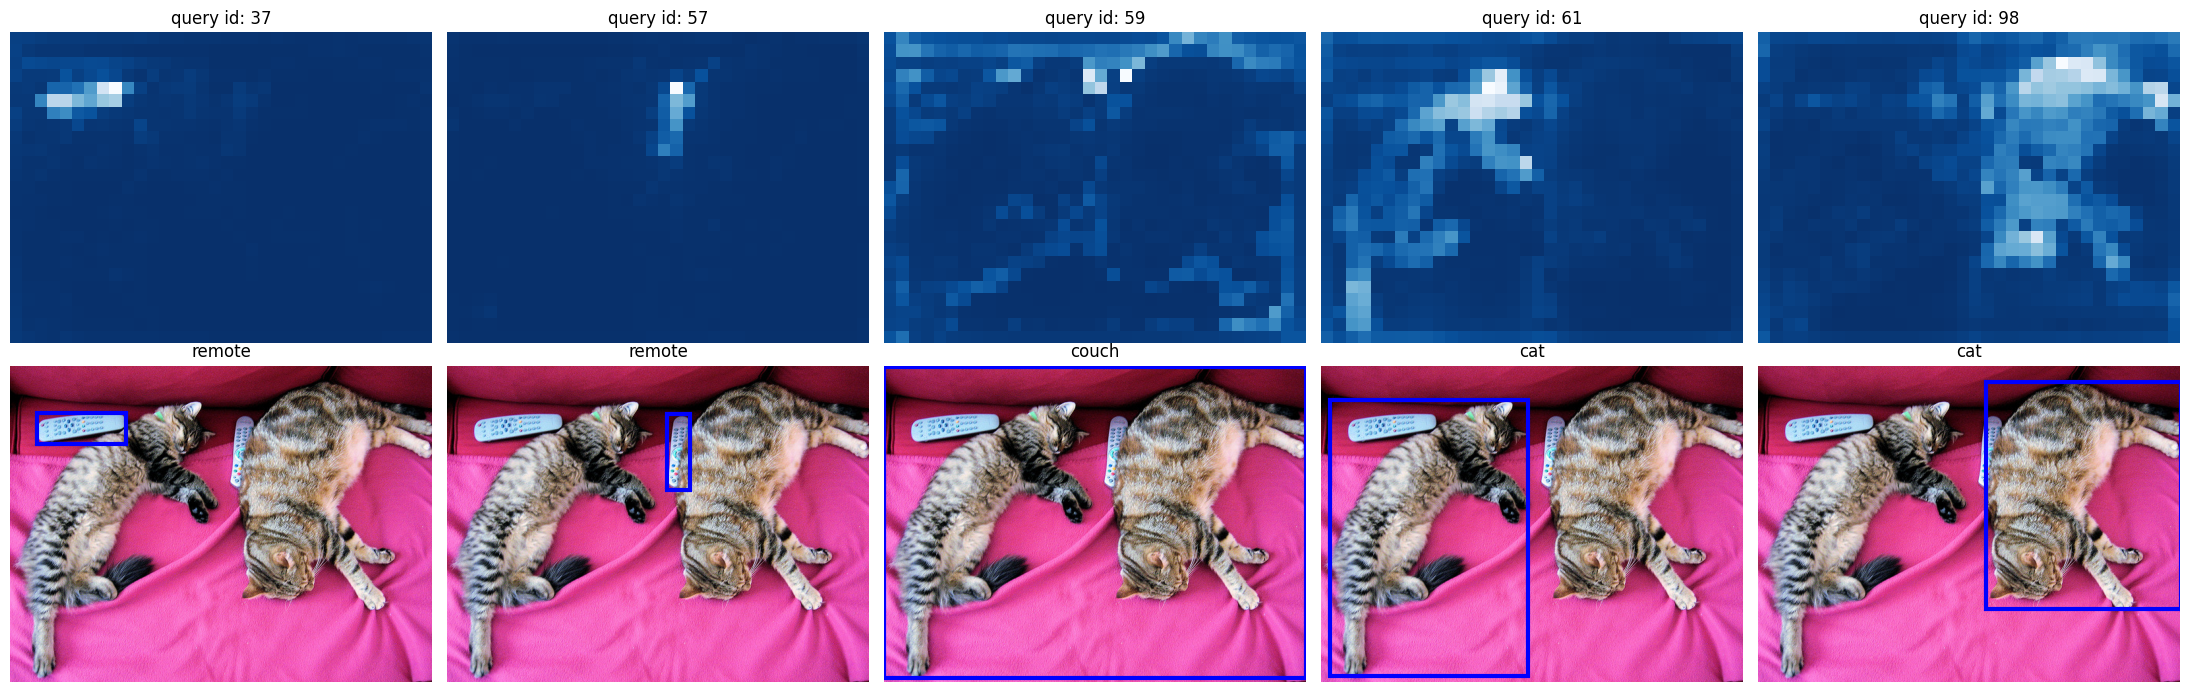

In [9]:
url = 'http://images.cocodataset.org/val2017/000000039769.jpg'
im = Image.open(requests.get(url, stream=True).raw)

results = evaluate(model, gen, im, 'cuda')

In [10]:
def evaluate_class_segmentation(model, gen, item, device, target_class_id):
    """
    Generate segmentation mask for a specific class
    
    Args:
        item: Dictionary from your CocoPerClass dataset
        target_class_id: The COCO category ID to segment
    """
    im = item['original_image']
    gt_mask = item['mask']
    category_name = item['category_name']
    
    # mean-std normalize the input image (batch-size: 1)
    img = transform(im).unsqueeze(0).to(device)
    
    # propagate through the model
    outputs = model(img)
    
    # Filter predictions for target class only
    probas = outputs['pred_logits'].softmax(-1)[0, :, :-1]
    class_scores = probas[:, target_class_id]  # COCO IDs are 1-indexed, model is 0-indexed
    keep = class_scores > 0.5
    
    if keep.nonzero().shape[0] == 0:
        # Return empty mask if no detections
        h, w = im.height, im.width
        return {
            'predicted_mask': torch.zeros((h, w), dtype=torch.uint8),
            'ground_truth_mask': gt_mask,
            'detected_objects': [],
            'confidence_scores': [],
            'target_class_id': target_class_id,
            'target_class_name': category_name
        }
    
    outputs['pred_boxes'] = outputs['pred_boxes'].cpu()
    keep = keep.cpu()
    
    # Get features for heatmap generation
    conv_features, enc_attn_weights, dec_attn_weights = [], [], []
    
    # Register hooks
    hooks = [
        model.backbone[-2].register_forward_hook(
            lambda self, input, output: conv_features.append(output)
        ),
        model.transformer.decoder.layers[-1].multihead_attn.register_forward_hook(
            lambda self, input, output: dec_attn_weights.append(output[1])
        ),
    ]
    
    for layer in model.transformer.encoder.layers:
        hook = layer.self_attn.register_forward_hook(
            lambda self, input, output: enc_attn_weights.append(output[1])
        )
        hooks.append(hook)
    
    model(img)
    
    for hook in hooks:
        hook.remove()
    
    conv_features = conv_features[0]
    h, w = conv_features['0'].tensors.shape[-2:]
    
    # Generate combined segmentation mask
    combined_mask = torch.zeros((h, w), dtype=torch.float32)
    detected_objects = []
    
    for i, idx in enumerate(keep.nonzero()):
        idx = idx.item()
        
        # Generate attention heatmap - fix the index parameter
        # Pass the target class ID explicitly to avoid the indexing error
        cam = gen.generate_ours(img, idx, index=target_class_id-1, use_lrp=False)
        cam = (cam - cam.min()) / (cam.max() - cam.min())
        heatmap = cam.view(h, w).data.cpu()
        
        # Threshold and add to combined mask
        binary_mask = (heatmap > 0.5).float()
        combined_mask = torch.maximum(combined_mask, binary_mask)
        
        detected_objects.append({
            'query_id': idx,
            'confidence': class_scores[idx].item(),
            'heatmap': heatmap.numpy()
        })
    
    # Resize mask to original image size
    combined_mask = torch.nn.functional.interpolate(
        combined_mask.unsqueeze(0).unsqueeze(0),
        size=(im.height, im.width),
        mode='bilinear',
        align_corners=False
    ).squeeze().round().byte()
    
    return {
        'predicted_mask': combined_mask,
        'ground_truth_mask': gt_mask,
        'detected_objects': detected_objects,
        'target_class_id': target_class_id,
        'target_class_name': category_name
    }

In [11]:
from torch.utils.data import DataLoader


In [12]:
def compute_segmentation_metrics(pred_mask, gt_mask):
    """
    Compute IoU, precision, recall for binary segmentation
    """
    pred_mask = pred_mask.bool()
    gt_mask = gt_mask.bool()
    
    intersection = (pred_mask & gt_mask).sum().float()
    union = (pred_mask | gt_mask).sum().float()
    
    iou = intersection / (union + 1e-7)
    precision = intersection / (pred_mask.sum().float() + 1e-7)
    recall = intersection / (gt_mask.sum().float() + 1e-7)
    
    return {
        'iou': iou.item(),
        'precision': precision.item(),
        'recall': recall.item()
    }

# Final

In [14]:
import numpy as np, cv2, torch
from tqdm.auto import tqdm
from skimage.filters import threshold_otsu
from pycocotools import mask as mu
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval

IOU_THR = 0.20
THR_FALLBACK = 0.30

def rle(arr):
    """Convert uint8 H×W array to RLE dict (json-safe)"""
    r = mu.encode(np.asfortranarray(arr))
    r["counts"] = r["counts"].decode("ascii")
    return r

def generate_detr_mask(model, gen, original_img, target_class_id, device):
    """Generate segmentation mask using DETR attention - TOP QUERY ONLY"""
    img = transform(original_img).unsqueeze(0).to(device)
    outputs = model(img)
    probas = outputs['pred_logits'].softmax(-1)[0, :, :-1]
    class_scores = probas[:, target_class_id]
    
    # Get the TOP query only (highest confidence)
    top_score, top_idx = class_scores.max(0)
    
    # Get feature dimensions
    conv_features = []
    hook = model.backbone[-2].register_forward_hook(
        lambda self, input, output: conv_features.append(output)
    )
    model(img)
    hook.remove()
    
    h, w = conv_features[0]['0'].tensors.shape[-2:]
    
    # Process ONLY the top query
    idx = top_idx.item()
    cam = gen.generate_ours(img, idx, index=target_class_id, use_lrp=False)
    cam = (cam - cam.min()) / (cam.max() - cam.min())
    combined_mask = cam.view(h, w).data.cpu()
    
    # Resize to original image size
    combined_mask_resized = torch.nn.functional.interpolate(
        combined_mask.unsqueeze(0).unsqueeze(0),
        size=(original_img.height, original_img.width),
        mode='bilinear',
        align_corners=False
    ).squeeze()
    
    return combined_mask_resized.numpy()

# Initialize data structures for DETR method only
data = {
    'images': [], 
    'anns_gt': [], 
    'anns_dt': [],
    'cls2id': {},
    'ann_id': 1
}

dataset = CocoPerClass(coco_det, transform=transform)
dataloader = DataLoader(dataset, batch_size=1, collate_fn=collate_fn)
# Main processing loop
for i, batch in enumerate(tqdm(dataloader, desc="Processing batches")):
    original_images = batch['original_images']
    masks = batch['masks']
    cls_names = batch['category_names']
    img_ids = batch['image_ids']
    category_ids = batch['category_ids']
    
    B = len(img_ids)
    
    # Process each sample
    for b in range(B):
        img_id = img_ids[b]
        gt_mask = masks[b]
        H, W = gt_mask.shape
        cls = cls_names[b]
        target_class_id = category_ids[b]
        original_img = original_images[b]
        
        if gt_mask.sum() == 0:
            continue
            
        # Prepare ground truth (same reliable logic as working code)
        gt_bin = (gt_mask > 0).numpy().astype(np.uint8)
        g_rle = rle(gt_bin)
        ys, xs = np.where(gt_bin)
        x0, x1, y0, y1 = xs.min(), xs.max()+1, ys.min(), ys.max()+1
        
        # Add ground truth
        cid = data['cls2id'].setdefault(cls, len(data['cls2id'])+1)
        data['images'].append({"id": img_id, "width": W, "height": H})
        data['anns_gt'].append({
            "id": data['ann_id'], "image_id": img_id, "category_id": cid,
            "segmentation": g_rle, "area": int(mu.area(g_rle)),
            "bbox": [x0,y0,x1-x0,y1-y0], "iscrowd": 0
        })
        data['ann_id'] += 1
        
        # Generate DETR prediction
        pred_mask = generate_detr_mask(model, gen, original_img, target_class_id, device)
        
        if pred_mask is not None:
            # Resize if needed
            if pred_mask.shape != (H, W):
                pred_mask = cv2.resize(pred_mask, (W, H), interpolation=cv2.INTER_LINEAR)
            
            # Process prediction (same thresholding logic as working code)
            h = pred_mask
            if np.isnan(h).any():
                continue
            thr = threshold_otsu(h)
            m = h >= thr
            if m.sum() == 0:
                m = h >= (h.max() * THR_FALLBACK)
            if m.sum() > 0:
                m_np = m.astype(np.uint8)
                d_rle = rle(m_np)
                ys, xs = np.where(m_np)
                x0, x1 = xs.min(), xs.max() + 1
                y0, y1 = ys.min(), ys.max() + 1
                data['anns_dt'].append({
                    "image_id": img_id, "category_id": cid, "score": 1.0,
                    "segmentation": d_rle, "bbox": [x0, y0, x1 - x0, y1 - y0]
                })

Processing batches:   0%|          | 0/14631 [00:00<?, ?it/s]

In [16]:
import os
import json
import numpy as np

def convert_numpy_types(obj):
    """Recursively convert numpy types to Python native types"""
    if isinstance(obj, np.integer):
        return int(obj)
    elif isinstance(obj, np.floating):
        return float(obj)
    elif isinstance(obj, np.ndarray):
        return obj.tolist()
    elif isinstance(obj, dict):
        return {key: convert_numpy_types(value) for key, value in obj.items()}
    elif isinstance(obj, list):
        return [convert_numpy_types(item) for item in obj]
    else:
        return obj

def save_detr_segmentation_data(data, filepath):
    """Save complete segmentation data for DETR method"""
    # Create directory if it doesn't exist
    os.makedirs(os.path.dirname(filepath), exist_ok=True)
    
    # Convert numpy types to Python native types
    clean_data = convert_numpy_types(data)
    
    # Add metadata
    save_data = {
        'method': 'detr',
        'metadata': {
            'iou_threshold': float(IOU_THR),
            'fallback_threshold': float(THR_FALLBACK),
            'total_images': len(data['images']),
            'total_gt_annotations': len(data['anns_gt']),
            'total_predictions': len(data['anns_dt']),
            'total_classes': len(data['cls2id'])
        },
        'data': clean_data
    }
    
    print(f"Saving DETR segmentation data to {filepath}...")
    print(f"  - Images: {len(data['images'])}")
    print(f"  - GT annotations: {len(data['anns_gt'])}")
    print(f"  - Predictions: {len(data['anns_dt'])}")
    print(f"  - Classes: {len(data['cls2id'])}")
    
    with open(filepath, 'w') as f:
        json.dump(save_data, f, indent=2)
    print("✓ DETR segmentation data saved!")

def load_detr_segmentation_data(filepath):
    """Load complete segmentation data for DETR method"""
    print(f"Loading DETR segmentation data from {filepath}...")
    
    with open(filepath, 'r') as f:
        save_data = json.load(f)
    
    data = save_data['data']
    metadata = save_data.get('metadata', {})
    method = save_data.get('method', 'detr')
    
    print(f"✓ Loaded DETR data:")
    print(f"  - Images: {len(data['images'])}")
    print(f"  - GT annotations: {len(data['anns_gt'])}")
    print(f"  - Predictions: {len(data['anns_dt'])}")
    print(f"  - Classes: {len(data['cls2id'])}")
    print(f"  - Class mapping: {data['cls2id']}")
    
    return data, metadata

In [17]:
# Save
# os.makedirs("../../final_results/", exist_ok=True)
# save_detr_segmentation_data(data, '../../final_results/segmentation/detr.json')

Saving DETR segmentation data to final_results/segmentation/detr.json...
  - Images: 14631
  - GT annotations: 14631
  - Predictions: 14631
  - Classes: 80
✓ DETR segmentation data saved!
Loading DETR segmentation data from final_results/segmentation/detr.json...
✓ Loaded DETR data:
  - Images: 14631
  - GT annotations: 14631
  - Predictions: 14631
  - Classes: 80
  - Class mapping: {'potted plant': 1, 'person': 2, 'dining table': 3, 'tv': 4, 'microwave': 5, 'refrigerator': 6, 'book': 7, 'clock': 8, 'vase': 9, 'chair': 10, 'bear': 11, 'bed': 12, 'truck': 13, 'car': 14, 'stop sign': 15, 'teddy bear': 16, 'skis': 17, 'oven': 18, 'baseball glove': 19, 'sports ball': 20, 'tennis racket': 21, 'backpack': 22, 'handbag': 23, 'boat': 24, 'cell phone': 25, 'bird': 26, 'train': 27, 'bowl': 28, 'sandwich': 29, 'surfboard': 30, 'laptop': 31, 'mouse': 32, 'keyboard': 33, 'bus': 34, 'cat': 35, 'airplane': 36, 'zebra': 37, 'tie': 38, 'traffic light': 39, 'apple': 40, 'baseball bat': 41, 'wine glass':

In [ ]:
# Load:
data_loaded, metadata = load_detr_segmentation_data('../../final_results/segmentation/detr.json')

In [22]:
def evaluate_detr_method(data, IOU_THR=0.5):
    """Evaluate DETR method using COCO APIs"""
    print("="*60)
    print("EVALUATING DETR")
    print("="*60)
    
    cats = [{'id': v, 'name': k} for k, v in data['cls2id'].items()]
    gt = {'images': data['images'], 'annotations': data['anns_gt'], 'categories': cats}
    
    print(f"DETR: {len(data['images'])} images, {len(data['anns_dt'])} predictions")
    
    if len(data['anns_dt']) == 0:
        print("No predictions to evaluate!")
        return 0.0
    
    coco_gt = COCO()
    coco_gt.dataset = gt
    coco_gt.createIndex()
    
    coco_dt = coco_gt.loadRes(data['anns_dt'])
    eval_obj = COCOeval(coco_gt, coco_dt, iouType="segm")
    eval_obj.params.iouThrs = np.array([IOU_THR])
    eval_obj.evaluate()
    eval_obj.accumulate()
    eval_obj.summarize()
    
    result = eval_obj.stats[0]  # mAP@IOU_THR (same as original code)
    
    print("="*60)
    print("FINAL RESULT")
    print("="*60)
    print(f"DETR mAP@{IOU_THR}: {result:.4f}")
    
    return result

# Run evaluation
final_score = evaluate_detr_method(data_loaded, IOU_THR)
print(f"\nFinal DETR Score: {final_score:.4f}")

EVALUATING DETR
DETR: 14631 images, 14631 predictions
creating index...
index created!
Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *segm*
DONE (t=5.15s).
Accumulating evaluation results...
DONE (t=0.61s).
 Average Precision  (AP) @[ IoU=0.20:0.20 | area=   all | maxDets=100 ] = 0.467
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.20:0.20 | area= small | maxDets=100 ] = 0.341
 Average Precision  (AP) @[ IoU=0.20:0.20 | area=medium | maxDets=100 ] = 0.526
 Average Precision  (AP) @[ IoU=0.20:0.20 | area= large | maxDets=100 ] = 0.539
 Average Recall     (AR) @[ IoU=0.20:0.20 | area=   all | maxDets=  1 ] = 0.644
 Average Recall     (AR) @[ IoU=0.20:0.20 | area=   all | maxDets= 10 ] = 0.644
 Average Recall     (AR) @[ IoU=0.20:0.20 | area=   all | m

In [25]:
import numpy as np
from pycocotools import mask as mu
from collections import defaultdict

def compute_iou(mask1_rle, mask2_rle):
    """Compute IoU between two RLE masks"""
    # Decode RLE to binary masks
    mask1 = mu.decode(mask1_rle)
    mask2 = mu.decode(mask2_rle)
    
    # Compute intersection and union
    intersection = np.logical_and(mask1, mask2).sum()
    union = np.logical_or(mask1, mask2).sum()
    
    if union == 0:
        return 0.0
    
    return intersection / union

def compute_detr_miou(data):
    """Compute mIOU for DETR method"""
    print("Computing mIOU for DETR...")
    
    # Group ground truth and predictions by image_id and category_id
    gt_by_img_cat = {}
    dt_by_img_cat = {}
    
    # Index ground truth
    for gt_ann in data['anns_gt']:
        key = (gt_ann['image_id'], gt_ann['category_id'])
        gt_by_img_cat[key] = gt_ann
    
    # Index predictions  
    for dt_ann in data['anns_dt']:
        key = (dt_ann['image_id'], dt_ann['category_id'])
        dt_by_img_cat[key] = dt_ann
    
    # Compute IoU for all ground truth annotations (penalize missing predictions)
    ious = []
    matched_pairs = 0
    
    for key, gt_ann in gt_by_img_cat.items():  # Iterate through all GT
        if key in dt_by_img_cat:
            gt_mask = gt_ann['segmentation']
            dt_mask = dt_by_img_cat[key]['segmentation']
            
            iou = compute_iou(gt_mask, dt_mask)
            ious.append(iou)
            matched_pairs += 1
        else:
            # Missing prediction: penalize with IoU = 0
            ious.append(0.0)
    
    if len(ious) == 0:
        return 0.0, 0
    
    miou = np.mean(ious)
    print(f"  DETR: {matched_pairs} matched pairs, mIOU = {miou:.4f}")
    
    return miou, matched_pairs

def compute_detr_miou_results(data):
    """Compute mIOU results for DETR method"""
    print("="*60)
    print("COMPUTING mIOU FOR DETR")
    print("="*60)
    
    miou, matched_pairs = compute_detr_miou(data)
    
    result = {
        'method': 'detr',
        'mIOU': miou,
        'matched_pairs': matched_pairs,
        'total_gt': len(data['anns_gt']),
        'total_predictions': len(data['anns_dt']),
        'coverage': matched_pairs / len(data['anns_gt']) if len(data['anns_gt']) > 0 else 0.0
    }
    
    # Print detailed results
    print("\n" + "="*40)
    print("DETR mIOU RESULTS")
    print("="*40)
    
    print(f"Method: DETR")
    print(f"mIOU: {result['mIOU']:.4f}")
    print(f"Matched pairs: {result['matched_pairs']}")
    print(f"Total GT annotations: {result['total_gt']}")
    print(f"Total predictions: {result['total_predictions']}")
    print(f"Coverage: {result['coverage']:.4f} ({result['coverage']*100:.1f}%)")
    
    print(f"\nFinal DETR mIOU: {result['mIOU']:.4f}")
    
    return result

# Compute mIOU for DETR method
miou_results = compute_detr_miou_results(data)

COMPUTING mIOU FOR DETR
Computing mIOU for DETR...
  DETR: 14631 matched pairs, mIOU = 0.3047

DETR mIOU RESULTS
Method: DETR
mIOU: 0.3047
Matched pairs: 14631
Total GT annotations: 14631
Total predictions: 14631
Coverage: 1.0000 (100.0%)

Final DETR mIOU: 0.3047
